<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1">Предобработка данных</a></span></li><li><span><a href="#Исследование-исходных-данных" data-toc-modified-id="Исследование-исходных-данных-2">Исследование исходных данных</a></span></li><li><span><a href="#Анализ-воронки-событий" data-toc-modified-id="Анализ-воронки-событий-3">Анализ воронки событий</a></span></li><li><span><a href="#Анализ-результатов-эксперимента" data-toc-modified-id="Анализ-результатов-эксперимента-4">Анализ результатов эксперимента</a></span><ul class="toc-item"><li><span><a href="#Сравнение-А/А-групп" data-toc-modified-id="Сравнение-А/А-групп-4.1">Сравнение А/А-групп</a></span></li><li><span><a href="#Сравнение-экспериментальных-групп" data-toc-modified-id="Сравнение-экспериментальных-групп-4.2">Сравнение экспериментальных групп</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5">Вывод</a></span></li></ul></div>

# Оценка результатов A/А/В-теста в мобильном приложении стартапа по продаже продуктов питания

**Объект исследования**: результаты А/А/В-эксперимента со шрифтами во всем приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Цель исследования**: оценить различие среди пользователей приложения с разными шрифтами. 

**Задачи**:
- Изучить воронку продаж. Как пользователи доходят до покупки? Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Оценить точность А/В теста сравнением контрольных А/А групп
- Проанализировать результаты А/А/В-теста

**Данные**: логи пользователей в контрольных группах 246, 247 и в экспериментальной группе 248.

## Предобработка данных

Сразу загружаем все необходимые для дальнейшей работы бибилотеки, а также исходные данные.

In [1]:
# сразу загрузим все необходимые библиотеки
import pandas as pd
import math as mth
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# загружаем данные, расположенные локально
data = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
# общая оценка доступных данных
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Пропуски отсутствуют. Переименуем столбцы. Отметим, что значения столбца 'DeviceIDHash' на самом деле не обязательно соответствуют уникальным пользователям (например, один пользователь может заходить с разных устройств), но из-за отсутствия других данных можно принять их по смыслу равными.

In [4]:
# переименуем столбцы
data = data.rename(columns = {'EventName' : 'event_name', 
                              'DeviceIDHash' : 'user_id', 
                              'EventTimestamp' : 'event_ts', 
                              'ExpId' : 'group'})

Исходные данные о времени событий даны в формате UNIX. Добавим столбец с временем в обычном формате и только с датой события.

In [5]:
# добавим столбец с датой и временем в стандартном виде
data['event_timestamp'] = pd.to_datetime(data['event_ts'], unit='s')

# добавим столбец только с датой события
data['event_date'] = pd.to_datetime(data['event_timestamp'].dt.date)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_ts         244126 non-null  int64         
 3   group            244126 non-null  int64         
 4   event_timestamp  244126 non-null  datetime64[ns]
 5   event_date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


,event_name,user_id,event_ts,group,event_timestamp,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим датафрейм на наличие дубликатов и удалим их, если они есть. 

In [6]:
print('Дубликатов:', data.duplicated().sum())
print()
data = data.drop_duplicates()
data.info()

Дубликатов: 413

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_ts         243713 non-null  int64         
 3   group            243713 non-null  int64         
 4   event_timestamp  243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


Датафрейм содержит данные о 244 тысячах событий. Исходные данные о времени даны в формате UNIX и для дальнейшего анализа были переведены в более привычный вид. Названия столбцов датафрейма приведены к стандартному виду. Было обнаружено и удалено 413 строк-дубликатов. 

## Исследование исходных данных

Исследуем доступные данные. Найдем количество уникальных пользователей и среднее количество событий на одного пользователя.

In [7]:
# количество уникальных пользователей
print(f"В датасете доступны данные о {data['user_id'].nunique()} уникальном пользователе.")
print(f"Среднее количество событий на пользователя: {len(data['user_id']) / data['user_id'].nunique(): .0f}")

В датасете доступны данные о 7551 уникальном пользователе.
Среднее количество событий на пользователя:  32


Всего в таблице данные о 244 тысячах событий и 7551 уникальном пользователе. 
На каждого пользователя в среднем приходится 32 события. 

Исследуем распределение количества событий по пользователям. Для этого сгруппируем данные по идентификаторам пользователей, посчитаем количество событий и отразим это на гистограмме и на "графике с усами".

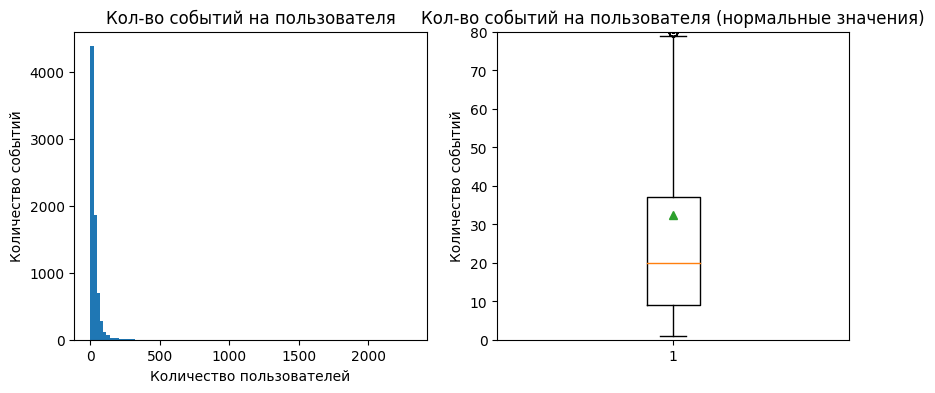

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                              figsize=(10, 4))
ax1.hist(data.groupby('user_id').agg({'event_name' : 'count'}),
        bins=100)
ax1.set_title('Кол-во событий на пользователя')
ax1.set_ylabel('Количество событий')
ax1.set_xlabel('Количество пользователей')

ax2.boxplot(data.groupby('user_id').agg({'event_name' : 'count'}),
           showmeans=True)
ax2.set_title('Кол-во событий на пользователя (нормальные значения)')
ax2.set_ylim(0,80)
ax2.set_ylabel('Количество событий');

Найдем максимальное количество событий, приходящееся на одного пользователя.

In [9]:
print(f"Максимальное количество событий на пользователя: {data.groupby('user_id').agg({'event_name' : 'count'}).max()[0]}")

Максимальное количество событий на пользователя: 2307


На большую часть пользователей приходится не более 80 событий, однако есть аномальные пользователи, для которых количество событий достигает 2307. Медианное значение находится на уровне 20 событий на пользователя. Среднее значение (32 события на пользователя) больше медианного, что обусловлено наличием выбросов.

Узнаем даты проведения эксперимента и построим распределение событий по времени. 

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


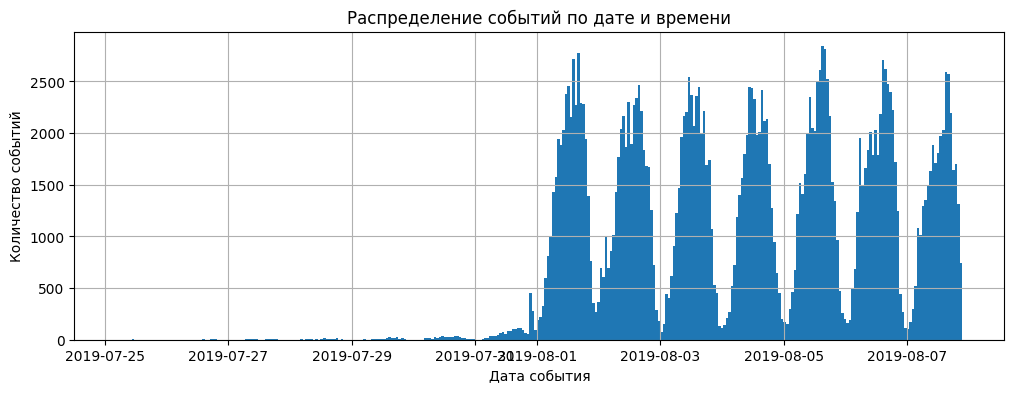

In [10]:
print('Минимальная дата:', data['event_timestamp'].min())
print('Максимальная дата:', data['event_timestamp'].max())

data['event_timestamp'].hist(figsize=(12, 4), bins=14*24)
plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата события')
plt.ylabel('Количество событий');

Минимальная дата, доступная в логе, – 25 июля 2019, максимальная – 7 августа 2019 года. Однако, по гистограмме видно, что данных за период до 1 августа очень мало. Скорее всего, это просто старые логи, которые "доехали" в выборку. Поэтому для дальнейшего анализа отберем только период с 1 по 7 августа. Основное количество событий происходит в дневное время, что видно по форме пиков на гистограмме.

Оценим, сколько данных не войдет в дальнейший анализ после фильтрации по дате. 

In [11]:
print('Число потерянных событий:', data[data['event_timestamp'] < '2019-08-01']['event_name'].count())
print(f"Доля потерянных событий: {(data[data['event_timestamp'] < '2019-08-01']['event_name'].count()) / data.shape[0]: .1%}")

# количество уникальных пользователей в исходных данных
before_users = data['user_id'].nunique() 
# кол-во пользователей в данных за 1 по 7 августа
after_users = data[data['event_timestamp'] >= '2019-08-01']['user_id'].nunique() 


print('Число потерянных пользователей:', before_users - after_users)
print(f'Доля потерянных пользователей: {(before_users - after_users) / before_users: .1%}')

Число потерянных событий: 2826
Доля потерянных событий:  1.2%
Число потерянных пользователей: 17
Доля потерянных пользователей:  0.2%


Общее число событий до 1 августа 2019 равно 2826, это примерно 1% от всех событий в логе. Число потерянных пользователей при очистке по дате равна 17, что составляет всего 0.2% от общего количества пользователей в логе.  

Фильтруем данные по дате, строим новое распределение.

Минимальная дата: 2019-08-01 00:07:28
Максимальная дата: 2019-08-07 21:15:17
Осталось уникальных пользователей: 7534


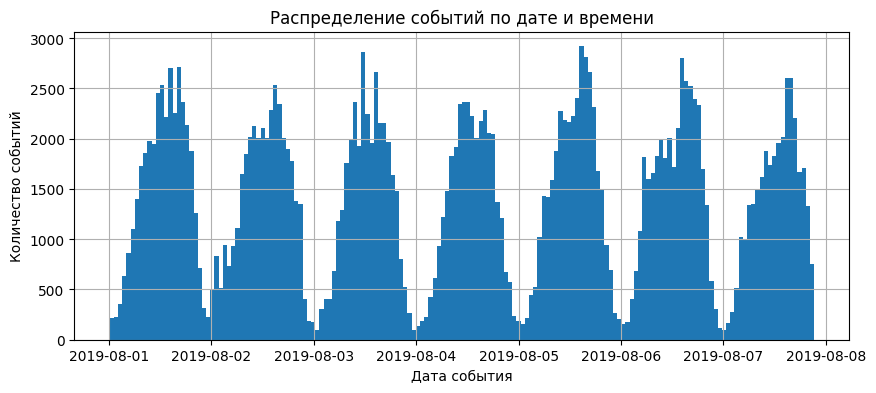

In [12]:
# оставляем события только с 1 по 7 августа 2019
data = data[data['event_timestamp'] >= '2019-08-01']
# проверяем данные после фильтрации
print('Минимальная дата:', data['event_timestamp'].min())
print('Максимальная дата:', data['event_timestamp'].max())
print('Осталось уникальных пользователей:', data['user_id'].nunique())

data['event_timestamp'].hist(figsize=(10, 4), bins=7*24)
plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата события')
plt.ylabel('Количество событий');

Проверяем, что в данных остались пользователи всех трех экспериментальных групп. 

In [13]:
data['group'].unique()

array([246, 247, 248])

Итого, в логе доступны полные данные только за 1 неделю проведения эксперимента – с 1 по 7 августа 2019 года. Всего описаны действия 7,5 тысяч пользователей, на каждого из которых приходится в среднем 32 события. В датасете приведены действия пользователей всех трех групп эксперимента.

## Анализ воронки событий

Исследуемых событий всего 5: появление на главном экране (`'MainScreenAppear'`), появление на экране предложений (`'OffersScreenAppear'`), появление экрана корзины (`'CartScreenAppear'`), появление экрана успешной оплаты (`'PaymentScreenSuccessful'`), обучающие материлы (`'Tutorial'`). 

Посмотрим распределение всех событий по этапам воронки на гистограмме.

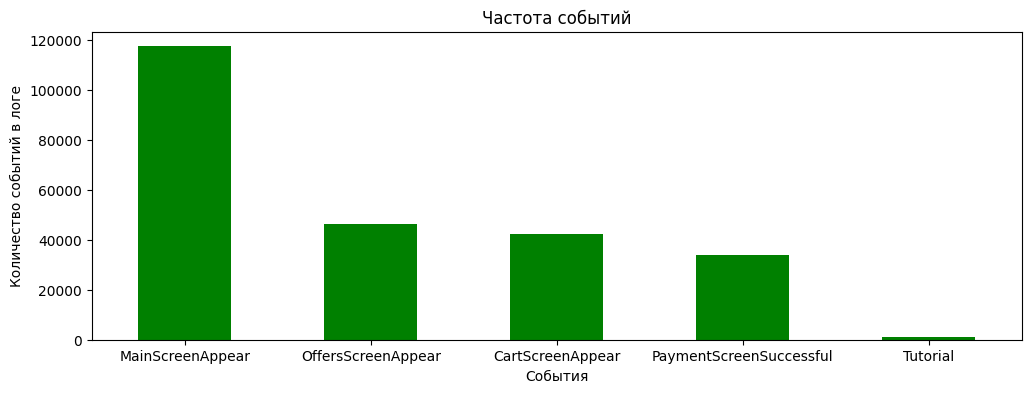

In [14]:
data.groupby('event_name')['event_name'].count().sort_values(ascending=False).plot.bar(rot=0, 
                                                                                    figsize=(12, 4), 
                                                                                    color='green')
plt.title('Частота событий')
plt.xlabel('События')
plt.ylabel('Количество событий в логе');

Чаще всего встречается событие `'MainScreenAppear'`, реже всего – `'Tutorial'`. Вероятно, обучающие материалы не очень популярны у пользователей. Отметим, что частота событий соотвествует логике использования приложения: появление главного экрана, экрана предложений, затем корзины и успешной оплаты следуют друг за другом. Событие `'Tutorial'` не входит в основную цепочку действий пользователя, поэтому в анализе воронки не будем его учитывать.  

Посчитаем, сколько уникальных пользователей совершали каждое событие. Найдем долю пользователей, которые хоть раз совершали действие каждого типа, от исходного количества пользователей на каждом этапе.

In [15]:
# найдем количество уникальных пользователей на каждом этапе
users_share = data[data['event_name'] != 'Tutorial'].pivot_table(index='event_name', 
                                                                 values='user_id', 
                                                                 aggfunc='nunique').sort_values(by='user_id', 
                                                                                                ascending=False)
# найдем долю пользователей на каждом этапе от всех уникальных пользователей в логе
users_share['share'] = round(users_share['user_id'] / data['user_id'].nunique(), 2)

# переименуем столбцы
users_share.columns = ['unique_users', 'share']
users_share = users_share.reset_index()

# рассчитаем долю пользователей на следюущем этапе от количества пользователей на предыдущем
users_share['step_share'] = (
    (users_share['unique_users'] / users_share['unique_users'].shift(1))
    .round(2)
    .fillna(1)
)
users_share

,event_name,unique_users,share,step_share
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


Всего почти 7,5 тысяч пользователей хотя бы раз видели главный экран (событие MainScreenAppear). Отметим, что 115 пользователей, данные о которых есть в общем логе, не вошли в воронку. От показа главного экрана к экрану предложений доходит 62% пользователей, от экрана предложений к корзине – 81%, от корзины к успешной оплате – 95%.  

```
# инициализация plotly для Jupyter Notebook
init_notebook_mode(connected=True)

# воронка в plotly
trace = go.Funnel(y=users_share['event_name'],
                 x=users_share['unique_users'],
                 textinfo='value+percent initial')

layout = go.Layout(title='Воронка событий')
fig = go.Figure(data=[trace], layout=layout)

fig.show()
```

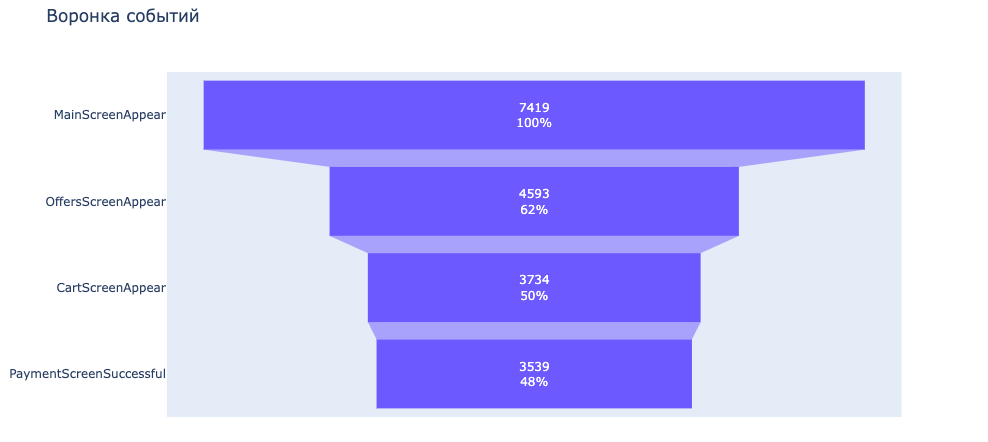

До появления экрана предложений доходят 62% исходного количества пользователей, экрана корзины – 50% и до оплаты доходит 48% пользователей. Наибольшая потеря происходит на пути от главного экрана к экрану с предложениями, как при расчете в долях от исходного количества пользователей, так и по отношению к предыдущему шагу. От первого события (главный экран) до оплаты доходит 47% пользователей.

## Анализ результатов эксперимента

Эксперимент проводился в формате А/А/В-теста, где было две контрольных группы и одна экспериментальная с новым шрифтом. 
Проверим, нет ли пользователей, которые попали в больше чем одну группу.

In [16]:
print(
    data.groupby('user_id')
        .agg({'group' : 'nunique'})
        .query('group>1')
)

Empty DataFrame
Columns: [group]
Index: []


Группы не пересекаются по пользователям. 

### Сравнение А/А-групп

Проверим, есть ли статистическая разница между контрольными выборками 246 и 247 (сравним доли уникальных пользователей в каждой из групп относительно общего количества уникальных пользователей в логе). 

Перед проведением статистического теста соберем все необходимые данные. Создадим сводную таблицу `tot_users` с общим количеством уникальных пользователей по группам. 

In [17]:
# из анализа исключаем событие Tutorial
tot_users = data[data['event_name'] != 'Tutorial'].pivot_table(columns='group', 
                                                            aggfunc={'user_id' : 'nunique'})
tot_users.columns = ['246', '247', '248']

# создаем объединенную контрольную группу
tot_users['246+247'] = tot_users['246'] + tot_users['247']

# добавляем общее количество уникальных пользователей во всем логе
tot_users['tot'] = data[data['event_name'] != 'Tutorial']['user_id'].nunique()

tot_users

,246,247,248,246+247,tot
user_id,2483,2512,2535,4995,7530


И сводную таблицу `tot_users_by_step` с количеством уникальных пользователей на каждом этапе воронки (кроме Tutorial). 

In [18]:
# из анализа исключаем событие Tutorial
tot_users_by_step = data[data['event_name'] != 'Tutorial'].pivot_table(index='event_name', 
                                                             columns='group', 
                                                             aggfunc={'user_id' : 'nunique'}).reset_index()

# переименуем столбцы
tot_users_by_step.columns = ['event_name', '246', '247', '248']

# создаем объединенную контрольную группу
tot_users_by_step['246+247'] = tot_users_by_step['246'] + tot_users_by_step['247']

tot_users_by_step = tot_users_by_step.sort_values(by='246', ascending=False)
tot_users_by_step

,event_name,246,247,248,246+247
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


За **нулевую гипотезу** принимаем утверждение о том, что пропорции пользователей (конверсия) для каждого события в экспериментальных группах равны друг другу (не имеют статистически значимых различий). 

**Альтернативная гипотеза** состоит в том, что группы значимо различаются (в большую или меньшую сторону). Так как тест двусторонний, удваиваем p_value.

Для статистического анализа экспериментальных групп по событиям напишем функцию для проведения z-теста. Аргументами функции являются: общее количество пользователей в каждой из двух сравниваемых групп (`trial_1` и `trial_2`), количество пользователей на этапе воронки в каждой из двух групп (`succ_1` и `succ_2`), а также p-value (по умолчанию задан 0.01). 

In [19]:
# функция проводит статистический тест на равенство пропорций в двух наборах данных (группах)
def z_test(trial_1, trial_2, succ_1, succ_2, alpha=.01):
    
    p1 = succ_1/trial_1 # пропорция успехов в первой группе
    p2 = succ_2/trial_2 # пропорция успехов во второй группе
    
    p_combined = (succ_1 + succ_2) / (trial_1 + trial_2) # пропорция успехов в комбинированном датасете
        
    difference = p1 - p2 # разница пропорций в датасетах
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trial_1 + 1/trial_2)) 
    distr = stats.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
        
    print('p-значение: ', p_value)
    
    # определяем, есть ли статистическая значимость в результате сравнения
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
                 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
             )
    print()

Также создадим отдельную функцию, которая "пройдется" по всем этапам (`event`) воронки в нашей таблице `tot_users_by_step` и выведет для них результат сравнения долей в двух группах (в функции они задаются как аргументы `group1` и `group2`). 

In [20]:
# функция проводит z-тест для всех событий в воронке для двух наборов данных (групп)
def data_for_z_test(trials, success, group1, group2, alpha=.01):
    for event in success['event_name']:
        print(event)
        succ_1 = success.loc[success['event_name'] == event, group1]
        succ_2 = success.loc[success['event_name'] == event, group2]
        
        trial_1 = trials[group1][0]
        trial_2 = trials[group2][0]
        
        
        z_test(trial_1, trial_2, succ_1, succ_2, alpha) 

Сравним доли пользователей на каждом этапе в контрольных группах `246` и `247`. 

In [21]:
print(
        data_for_z_test(tot_users, tot_users_by_step, '246', '247')
)

MainScreenAppear
p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

None


В долях пользователей, совершивших каждое событие, в контрольных группах `246` и `247` не было обнаружено статистически значимого различия.

### Сравнение экспериментальных групп 

Сравним экспериментальную группу `248` с каждой из контрольных.

In [22]:
print(
        data_for_z_test(tot_users, tot_users_by_step, '246', '248')
)

MainScreenAppear
p-значение:  [0.33871141]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  [0.21693034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

None


In [23]:
print(
        data_for_z_test(tot_users, tot_users_by_step, '247', '248')
)

MainScreenAppear
p-значение:  [0.51949644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  [0.93337513]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  [0.58782846]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  [0.72757187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

None


Не обнаружено статистически значимых различий экспериментальной группы с контрольными группами. 

Теперь сравним экспериментальную группу `248` с объединенной контрольной группой `246+247`. 

In [24]:
print(
        data_for_z_test(tot_users, tot_users_by_step, '246+247', '248')
)

MainScreenAppear
p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

None


Таким образом, во-первых, было показано, что контрольные группы А/А не различаются. Во-вторых, группа с измененными шрифтами не отличается от контрольных по результатам проверки гипотезы о равенстве долей методом z-теста. 

При проверке статистических гипотез был выбран уровень значимости 0.01, что позволяет снизить вероятность получить ошибку первого рода (или иначе – ложнопозитивный результат), то есть получить статистически значимое различие там, где его на самом деле нет. Так как в исследовании проводится множественное сравнение (сравниваем результаты групп А, А и В + объединенная группа А+А), то увеличение уровня значимости до 0.05 уже значительно увеличит получить ошибку первого рода, так как вероятность ошибиться в случае множественных сравнений находится по формуле 1 – (1-alpha) ^ k, где k – число сравниваемых экспериментов (так, при значении alpha = 0.05 при сравнении 4-х экспериментов вероятность хотя бы одного ложнопозитивного результата уже примерно 18.55%). Поэтому в данном случае, без применения поправок вроде поправки Бонферрони, значение alpha = 0.01 является наиболее оптимальным вариантом для расчета.   

## Вывод

Было проведено исследование данных о действиях пользователей в мобильном приложении за одну неделю с 1 по 7 августа 2019 (за этот период доступны наиболее полные данные). В датафрейме присутствуют записи о примерно 240 тысячах событий. Уникальных пользователей  7,5 тысячи, следовательно, на каждого приходится в среднем 32 события. 

Исследуемых событий всего 5: появление главного экрана ('MainScreenAppear'), появление на экране предложений ('OffersScreenAppear'), появление экрана корзины ('CartScreenAppear'), появление экрана успешной оплаты ('PaymentScreenSuccessful'), обучающие материлы ('Tutorial'). Все события, кроме tutorial (которое не учитываем в дальнейшем анализе), встраиваются в последовательную цепочку действий пользователя. 

Самое частое событие – появление главного экрана (117 тысяч раз). График воронки событий показал, что до следующего этапа (показ предложений) доходит лишь 62% уникальных пользователей, это наименьшая конверсия по сравнению со всеми остальными доступными событиями. От показа предоложений до экрана корзины доходит 50% от исходного количества уникальных пользователей или 81% от предыдущего шага. До оформления заказа (экран успешной оплаты) доходит 48% пользователей от исходного количества или 95% от пользователей на предыдущем шаге. Таким образом, 48% от всех пользователей приложения оплачивает в нем заказ. 

Для дальнейшего развития стартапа имеет смысл попытаться увеличить конверсию пользователей в заказ на самом первом этапе – от показа главного экрана. Возможно, решением может быть добавление на экран специальных предложений, товаров со скидками, "избранных" товаров, добавление промокодов на первый и последующий заказы. 

Проведение А/А/В-теста не показало статистически значимую разницу между долями пользователей на каждом шаге воронки. То есть разница в конверсии пользователей в приложении со старыми шрифтами по сравнению с версией с новыми шрифтами отсутствует. Следовательно, дополнительная работа по обновлению шрифтов не повлияет на конверсию пользователей в клиентов в приложении. 